# Unscented KalmanNet (UKN) Toy Pipeline
Duffing oscillator (state **x=[p,v]**, nx=2) with **2 unknown parameters θ=[k, α]** (nθ=2) that enter **only the dynamics f**.

**Measurement is nonlinear (ny=2):**
$$y_1 = p + a_p p^3 + v_{1},\quad y_2 = v + a_v v^3 + v_{2}$$

This notebook:
1. Generates and saves **train/test** datasets (`.pt`)
2. Trains **UKN = UKF backbone + GainNet(MLP→GRU→heads)**
3. Evaluates vs baseline **Augmented UKF**
4. Saves histories & predictions
5. Plots: training curve, 99% error bands, and one example trajectory

---
✅ GPU is auto-detected (CUDA → MPS → CPU).


In [1]:

# ====== Setup: imports, device, seeds ======
import os, json, math, time
from dataclasses import dataclass
from datetime import datetime
from typing import Dict, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

def get_best_device(force_cpu: bool = False) -> torch.device:
    if force_cpu:
        return torch.device("cpu")
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

DEVICE = get_best_device(force_cpu=False)
print("Torch:", torch.__version__)
print("Device:", DEVICE)
if DEVICE.type == "cuda":
    print("CUDA GPU:", torch.cuda.get_device_name(0))
elif DEVICE.type == "mps":
    print("Apple MPS enabled")

# Reproducibility (note: exact reproducibility on GPU can still vary)
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)


Torch: 2.10.0+cu128
Device: cuda
CUDA GPU: NVIDIA RTX 3500 Ada Generation Laptop GPU


## 1) Math/Linear Algebra helpers (SPD, Cholesky, UT weights)

In [2]:

def symmetrize(A: torch.Tensor) -> torch.Tensor:
    return 0.5 * (A + A.transpose(-1, -2))

def project_spd(A: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    A = symmetrize(A)
    evals, evecs = torch.linalg.eigh(A)
    evals = torch.clamp(evals, min=eps)
    return (evecs * evals.unsqueeze(-2)) @ evecs.transpose(-1, -2)

def safe_cholesky(A: torch.Tensor, jitter: float = 1e-6, max_tries: int = 6) -> torch.Tensor:
    A = symmetrize(A)
    n = A.shape[-1]
    if A.dim() == 2:
        I = torch.eye(n, device=A.device, dtype=A.dtype)
    else:
        B = A.shape[0]
        I = torch.eye(n, device=A.device, dtype=A.dtype).expand(B, -1, -1)

    for i in range(max_tries):
        try:
            return torch.linalg.cholesky(A + (jitter * (10**i)) * I)
        except RuntimeError:
            continue

    A_spd = project_spd(A, eps=jitter)
    return torch.linalg.cholesky(A_spd)

@dataclass
class UTParams:
    alpha: float = 0.8
    beta: float = 2.0
    kappa: float = 0.0

def unscented_weights(n: int, params: UTParams, device=None, dtype=None):
    alpha, beta, kappa = params.alpha, params.beta, params.kappa
    lam = alpha**2 * (n + kappa) - n
    c = n + lam
    wm = torch.full((2*n+1,), 1.0/(2.0*c), device=device, dtype=dtype)
    wc = torch.full((2*n+1,), 1.0/(2.0*c), device=device, dtype=dtype)
    wm[0] = lam / c
    wc[0] = lam / c + (1.0 - alpha**2 + beta)
    sqrt_c = math.sqrt(c)
    return wm, wc, sqrt_c

def sigma_points(mean: torch.Tensor, cov: torch.Tensor, sqrt_c: float, jitter: float = 1e-6):
    # mean: (B,n), cov: (B,n,n) -> sigma: (B,2n+1,n)
    B, n = mean.shape
    L = safe_cholesky(cov, jitter=jitter)  # (B,n,n)
    scaled = sqrt_c * L
    A = scaled.transpose(1, 2)  # columns as rows
    m = mean.unsqueeze(1)
    return torch.cat([m, m + A, m - A], dim=1)


## 2) Toy system: Duffing dynamics + nonlinear measurement
- Augmented state: z=[p, v, k, α] (n=4)
- Dynamics f: Duffing oscillator (θ only in f)
- Measurement h (nonlinear): y=[p+ap*p³, v+av*v³] + noise


In [3]:

@dataclass
class ToyConfig:
    dt: float = 0.05
    c: float = 0.25
    ap: float = 0.1
    av: float = 0.1

    # simulation process noise (x only)
    Qx_p: float = 1e-5
    Qx_v: float = 1e-4

    # measurement noise (in measurement space)
    sigma_meas: float = 0.05
    outlier: bool = True
    p_out: float = 0.05
    outlier_scale: float = 25.0  # Rout = scale * R0

    # input
    u_refresh: int = 5
    u_min: float = -1.0
    u_max: float = 1.0

    # parameter distribution
    k_min: float = 0.8
    k_max: float = 1.2
    alpha_min: float = 0.2
    alpha_max: float = 0.6

    # initial state distribution
    p0_mean: float = 1.0
    p0_std: float = 0.2
    v0_mean: float = 0.0
    v0_std: float = 0.2

def f_duffing(z: torch.Tensor, u: torch.Tensor, dt: float, c: float) -> torch.Tensor:
    # z: (...,4), u: broadcastable
    p = z[..., 0]
    v = z[..., 1]
    k = z[..., 2]
    alpha = z[..., 3]
    p_next = p + dt * v
    v_next = v + dt * (-c * v - k * p - alpha * (p**3) + u)
    return torch.stack([p_next, v_next, k, alpha], dim=-1)

def h_nonlinear(z: torch.Tensor, ap: float, av: float) -> torch.Tensor:
    p = z[..., 0]
    v = z[..., 1]
    y1 = p + ap * (p**3)
    y2 = v + av * (v**3)
    return torch.stack([y1, y2], dim=-1)

def invert_cubic_measurement(y: torch.Tensor, a: float, n_iter: int = 6, eps: float = 1e-6) -> torch.Tensor:
    # Solve x + a x^3 = y via Newton
    x = y.clone()
    for _ in range(n_iter):
        f = x + a * (x**3) - y
        fp = 1.0 + 3.0 * a * (x**2)
        x = x - f / (fp + eps)
    return x

def approx_inverse_h(y: torch.Tensor, ap: float, av: float) -> torch.Tensor:
    p_est = invert_cubic_measurement(y[..., 0], ap)
    v_est = invert_cubic_measurement(y[..., 1], av)
    return torch.stack([p_est, v_est], dim=-1)


## 3) UKF backbone (predict + measurement stats + generalized Joseph update)

In [5]:

def ukf_predict(z: torch.Tensor, P: torch.Tensor, u_prev: torch.Tensor, Q: torch.Tensor,
                wm: torch.Tensor, wc: torch.Tensor, sqrt_c: float,
                dt: float, c: float, jitter: float = 1e-6):
    # z: (B,n), P:(B,n,n), u_prev:(B,) -> z_pred,P_pred,X_sigma
    B, n = z.shape
    sig = sigma_points(z, P, sqrt_c, jitter=jitter)  # (B,S,n)
    u_b = u_prev.view(B, 1)                          # (B,1)
    X_sigma = f_duffing(sig, u_b, dt=dt, c=c)        # (B,S,n)

    z_pred = torch.sum(X_sigma * wm.view(1, -1, 1), dim=1)
    dX = X_sigma - z_pred.unsqueeze(1)
    P_pred = torch.einsum('bsi,bsj,s->bij', dX, dX, wc)

    if Q.dim() == 2:
        P_pred = P_pred + Q.unsqueeze(0)
    else:
        P_pred = P_pred + Q
    P_pred = symmetrize(P_pred) + jitter * torch.eye(n, device=z.device, dtype=z.dtype).unsqueeze(0)
    return z_pred, P_pred, X_sigma

def ukf_measurement_stats(z_pred: torch.Tensor, P_pred: torch.Tensor, X_sigma: torch.Tensor,
                          R: torch.Tensor, wm: torch.Tensor, wc: torch.Tensor,
                          ap: float, av: float, jitter: float = 1e-6):
    # y_pred, S, P_zy from sigma points
    B, S, n = X_sigma.shape
    ny = R.shape[-1]

    Y_sigma = h_nonlinear(X_sigma, ap=ap, av=av)      # (B,S,ny)
    y_pred = torch.sum(Y_sigma * wm.view(1, -1, 1), dim=1)

    dY = Y_sigma - y_pred.unsqueeze(1)
    dX = X_sigma - z_pred.unsqueeze(1)

    S_cov = torch.einsum('bsi,bsj,s->bij', dY, dY, wc)
    if R.dim() == 2:
        S_cov = S_cov + R.unsqueeze(0)
    else:
        S_cov = S_cov + R
    S_cov = symmetrize(S_cov) + jitter * torch.eye(ny, device=z_pred.device, dtype=z_pred.dtype).unsqueeze(0)

    P_zy = torch.einsum('bsi,bsj,s->bij', dX, dY, wc)  # (B,n,ny)
    return y_pred, S_cov, P_zy

def compute_K_ukf(P_zy: torch.Tensor, S: torch.Tensor, jitter: float = 1e-6):
    cholS = safe_cholesky(S, jitter=jitter)
    K_T = torch.cholesky_solve(P_zy.transpose(-1, -2), cholS)  # (B,ny,n)
    K = K_T.transpose(-1, -2)                                  # (B,n,ny)
    return K, cholS

def generalized_joseph(P_pred: torch.Tensor, K: torch.Tensor, S: torch.Tensor, P_zy: torch.Tensor,
                       jitter: float = 1e-6):
    P_yz = P_zy.transpose(-1, -2)  # (B,ny,n)
    P_post = P_pred - (K @ P_yz) - (P_zy @ K.transpose(-1, -2)) + (K @ S @ K.transpose(-1, -2))
    P_post = symmetrize(P_post) + jitter * torch.eye(P_pred.shape[-1], device=P_pred.device, dtype=P_pred.dtype).unsqueeze(0)
    return P_post


## 4) GainNet (MLP → GRU → heads) + UKN Filter
**Outputs:** ΔK (4×2) and row-wise gates (ρx, ρθ).

**Features (Core-20):**
- whitened innovation, NIS, logdet(S)
- Δz⁻, log diag(P⁻)
- whitened cross-cov C_{θy}
- δz_ukf = K_ukf ν


In [ ]:

class GainNet(nn.Module):
    def __init__(self,
                 d_in: int = 20,
                 hidden: int = 32,
                 embed: int = 32,
                 deltaK_scale: float = 0.1,
                 rho_theta_max: float = 0.3,
                 init_rho_bias: Tuple[float, float] = (-3.0, -5.0)):
        super().__init__()
        self.deltaK_scale = deltaK_scale
        self.rho_theta_max = rho_theta_max

        self.ln = nn.LayerNorm(d_in)
        self.enc = nn.Sequential(
            nn.Linear(d_in, embed), nn.ReLU(),
            nn.Linear(embed, embed), nn.ReLU(),
        )
        self.gru = nn.GRUCell(embed, hidden)

        self.trunk = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU())

        self.dk_head = nn.Sequential(
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 8),
        )
        self.gate_head = nn.Linear(hidden, 2)

        # Init: start near UKF (ΔK ~ 0, rho ~ small)
        nn.init.zeros_(self.dk_head[-1].weight)
        nn.init.zeros_(self.dk_head[-1].bias)
        nn.init.zeros_(self.gate_head.weight)
        self.gate_head.bias.data[:] = torch.tensor(init_rho_bias, dtype=self.gate_head.bias.dtype)

    def forward(self, feat: torch.Tensor, h: torch.Tensor, K_ukf: torch.Tensor):
        x = self.ln(feat)
        x = self.enc(x)
        h_new = self.gru(x, h)
        t = self.trunk(h_new)

        dk_raw = self.dk_head(t)     # (B,8)
        gate_raw = self.gate_head(t) # (B,2)

        rho_x = torch.sigmoid(gate_raw[:, 0:1])                    # (B,1)
        rho_theta = self.rho_theta_max * torch.sigmoid(gate_raw[:, 1:2])

        scale = self.deltaK_scale * torch.linalg.norm(K_ukf.reshape(K_ukf.shape[0], -1),
                                                      dim=-1, keepdim=True)  # (B,1)
        deltaK = (scale * torch.tanh(dk_raw)).view(-1, 4, 2)
        return deltaK, rho_x, rho_theta, h_new

class UKNFilter(nn.Module):
    def __init__(self,
                 toy: ToyConfig,
                 ut_params: UTParams = UTParams(alpha=0.8, beta=2.0, kappa=0.0),
                 Q: Optional[torch.Tensor] = None,
                 R: Optional[torch.Tensor] = None,
                 jitter: float = 1e-6,
                 feature_eps: float = 1e-8,
                 hidden: int = 32,
                 deltaK_scale: float = 0.1,
                 rho_theta_max: float = 0.3):
        super().__init__()
        self.toy = toy
        self.jitter = jitter
        self.feature_eps = feature_eps
        self.n_z = 4
        self.n_y = 2

        if Q is None:
            Q = torch.diag(torch.tensor([1e-5, 1e-4, 1e-6, 1e-6], dtype=torch.float32))
        if R is None:
            sigma = toy.sigma_meas
            R = torch.diag(torch.tensor([sigma**2, sigma**2], dtype=torch.float32))

        self.register_buffer("Q", Q)
        self.register_buffer("R", R)

        wm, wc, sqrt_c = unscented_weights(self.n_z, ut_params, device=Q.device, dtype=Q.dtype)
        self.register_buffer("wm", wm)
        self.register_buffer("wc", wc)
        self.sqrt_c = sqrt_c

        self.hidden = hidden
        self.gain_net = GainNet(d_in=20, hidden=hidden, embed=32,
                                deltaK_scale=deltaK_scale,
                                rho_theta_max=rho_theta_max)

    def _build_features(self, nu, cholS, z_pred, P_pred, P_zy, K_ukf, z_prev_ref):
        B = nu.shape[0]
        # whitened innovation
        tilde_nu = torch.linalg.solve_triangular(cholS, nu.unsqueeze(-1), upper=False).squeeze(-1)  # (B,2)
        nis = torch.sum(tilde_nu**2, dim=-1, keepdim=True)                                          # (B,1)
        logdetS = 2.0 * torch.sum(torch.log(torch.diagonal(cholS, dim1=-2, dim2=-1) + self.feature_eps),
                                  dim=-1, keepdim=True)                                             # (B,1)

        delta_z_pred = z_pred - z_prev_ref                                                           # (B,4)
        logdiagP = torch.log(torch.diagonal(P_pred, dim1=-2, dim2=-1) + self.feature_eps)            # (B,4)

        # whitened cross-cov for theta-y:
        P_theta_y = P_zy[:, 2:4, :]         # (B,2,2)
        P_theta_theta = P_pred[:, 2:4, 2:4] # (B,2,2)
        L_theta = safe_cholesky(P_theta_theta, jitter=self.jitter)
        C_temp = torch.linalg.solve_triangular(L_theta, P_theta_y, upper=False)                      # (B,2,2)

        I = torch.eye(self.n_y, device=nu.device, dtype=nu.dtype).expand(B, -1, -1)
        inv_LS = torch.linalg.solve_triangular(cholS, I, upper=False)                                # (B,2,2)
        C_theta_y = C_temp @ inv_LS.transpose(-1, -2)                                                # (B,2,2)
        vecC = C_theta_y.reshape(B, -1)                                                              # (B,4)

        delta_z_ukf = (K_ukf @ nu.unsqueeze(-1)).squeeze(-1)                                         # (B,4)

        feat = torch.cat([tilde_nu, nis, logdetS, delta_z_pred, logdiagP, vecC, delta_z_ukf], dim=-1)
        return feat

    def forward(self, y: torch.Tensor, u: torch.Tensor, z0: torch.Tensor, P0: torch.Tensor):
        B, T, _ = y.shape
        z, P = z0, P0
        h = torch.zeros(B, self.hidden, device=y.device, dtype=y.dtype)

        z_hist = []
        z_prev = z.clone()

        for t in range(T):
            if t == 0:
                z_pred, P_pred = z, P
                X_sigma = sigma_points(z_pred, P_pred, self.sqrt_c, jitter=self.jitter)
                z_prev_ref = z_pred
            else:
                z_pred, P_pred, X_sigma = ukf_predict(z, P, u[:, t-1], self.Q,
                                                      self.wm, self.wc, self.sqrt_c,
                                                      dt=self.toy.dt, c=self.toy.c, jitter=self.jitter)
                z_prev_ref = z_prev

            y_pred, S, P_zy = ukf_measurement_stats(z_pred, P_pred, X_sigma, self.R,
                                                    self.wm, self.wc,
                                                    ap=self.toy.ap, av=self.toy.av,
                                                    jitter=self.jitter)
            nu = y[:, t, :] - y_pred
            K_ukf, cholS = compute_K_ukf(P_zy, S, jitter=self.jitter)

            feat = self._build_features(nu, cholS, z_pred, P_pred, P_zy, K_ukf, z_prev_ref)
            deltaK, rho_x, rho_theta, h = self.gain_net(feat, h, K_ukf)

            g_row = torch.cat([rho_x, rho_x, rho_theta, rho_theta], dim=-1)  # (B,4)
            K = K_ukf + deltaK * g_row.unsqueeze(-1)

            z_post = z_pred + (K @ nu.unsqueeze(-1)).squeeze(-1)
            P_post = generalized_joseph(P_pred, K, S, P_zy, jitter=self.jitter)

            z_hist.append(z_post)
            z_prev = z_post
            z, P = z_post, P_post

        return torch.stack(z_hist, dim=1)

class AugmentedUKF(nn.Module):
    def __init__(self, toy: ToyConfig,
                 ut_params: UTParams = UTParams(alpha=0.8, beta=2.0, kappa=0.0),
                 Q: Optional[torch.Tensor] = None,
                 R: Optional[torch.Tensor] = None,
                 jitter: float = 1e-6):
        super().__init__()
        self.toy = toy
        self.jitter = jitter
        self.n_z = 4
        if Q is None:
            Q = torch.diag(torch.tensor([1e-5, 1e-4, 1e-6, 1e-6], dtype=torch.float32))
        if R is None:
            sigma = toy.sigma_meas
            R = torch.diag(torch.tensor([sigma**2, sigma**2], dtype=torch.float32))
        self.register_buffer("Q", Q)
        self.register_buffer("R", R)
        wm, wc, sqrt_c = unscented_weights(self.n_z, ut_params, device=Q.device, dtype=Q.dtype)
        self.register_buffer("wm", wm)
        self.register_buffer("wc", wc)
        self.sqrt_c = sqrt_c

    def forward(self, y: torch.Tensor, u: torch.Tensor, z0: torch.Tensor, P0: torch.Tensor):
        B, T, _ = y.shape
        z, P = z0, P0
        z_hist = []
        for t in range(T):
            if t == 0:
                z_pred, P_pred = z, P
                X_sigma = sigma_points(z_pred, P_pred, self.sqrt_c, jitter=self.jitter)
            else:
                z_pred, P_pred, X_sigma = ukf_predict(z, P, u[:, t-1], self.Q,
                                                      self.wm, self.wc, self.sqrt_c,
                                                      dt=self.toy.dt, c=self.toy.c, jitter=self.jitter)

            y_pred, S, P_zy = ukf_measurement_stats(z_pred, P_pred, X_sigma, self.R,
                                                    self.wm, self.wc,
                                                    ap=self.toy.ap, av=self.toy.av,
                                                    jitter=self.jitter)
            nu = y[:, t, :] - y_pred
            K_ukf, _ = compute_K_ukf(P_zy, S, jitter=self.jitter)
            z_post = z_pred + (K_ukf @ nu.unsqueeze(-1)).squeeze(-1)
            P_post = generalized_joseph(P_pred, K_ukf, S, P_zy, jitter=self.jitter)
            z_hist.append(z_post)
            z, P = z_post, P_post
        return torch.stack(z_hist, dim=1)


## 5) Dataset generation, saving, loading
We generate `train.pt` and `test.pt` so training/testing are repeatable.


In [ ]:

class SequenceDataset(Dataset):
    def __init__(self, pt_path: str):
        blob = torch.load(pt_path, map_location="cpu")
        self.x = blob["x"]          # (N,T,2)
        self.y = blob["y"]          # (N,T,2)
        self.theta = blob["theta"]  # (N,2)
        self.u = blob["u"]          # (N,T)
        self.config = blob["config"]
        self.meta = blob.get("meta", {})

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return {"x": self.x[idx], "y": self.y[idx], "theta": self.theta[idx], "u": self.u[idx]}

def simulate_duffing_dataset(N: int, T: int, cfg: ToyConfig, seed: int) -> Dict[str, torch.Tensor]:
    rng = np.random.default_rng(seed)

    Qx = np.diag([cfg.Qx_p, cfg.Qx_v]).astype(np.float32)

    sigma = cfg.sigma_meas
    R0 = np.diag([sigma**2, sigma**2]).astype(np.float32)
    Rout = (cfg.outlier_scale * R0).astype(np.float32)

    x = np.zeros((N, T, 2), dtype=np.float32)
    y = np.zeros((N, T, 2), dtype=np.float32)
    u = np.zeros((N, T), dtype=np.float32)
    theta = np.zeros((N, 2), dtype=np.float32)

    for n in range(N):
        k = rng.uniform(cfg.k_min, cfg.k_max)
        alpha = rng.uniform(cfg.alpha_min, cfg.alpha_max)
        theta[n] = [k, alpha]

        # input (piecewise constant)
        for t in range(T):
            if t % cfg.u_refresh == 0:
                u[n, t] = rng.uniform(cfg.u_min, cfg.u_max)
            else:
                u[n, t] = u[n, t-1]

        # init
        x[n, 0, 0] = rng.normal(cfg.p0_mean, cfg.p0_std)
        x[n, 0, 1] = rng.normal(cfg.v0_mean, cfg.v0_std)

        # simulate dynamics
        for t in range(T-1):
            p, v = x[n, t]
            w = rng.multivariate_normal(np.zeros(2), Qx)
            p_next = p + cfg.dt * v + w[0]
            v_next = v + cfg.dt * (-cfg.c*v - k*p - alpha*(p**3) + u[n, t]) + w[1]
            x[n, t+1] = [p_next, v_next]

        # measurement (nonlinear + additive noise in measurement space)
        for t in range(T):
            p, v = x[n, t]
            y_clean = np.array([p + cfg.ap*(p**3), v + cfg.av*(v**3)], dtype=np.float32)
            if cfg.outlier and (rng.uniform() < cfg.p_out):
                v_meas = rng.multivariate_normal(np.zeros(2), Rout)
            else:
                v_meas = rng.multivariate_normal(np.zeros(2), R0)
            y[n, t] = y_clean + v_meas.astype(np.float32)

    return {"x": torch.from_numpy(x), "y": torch.from_numpy(y), "theta": torch.from_numpy(theta), "u": torch.from_numpy(u)}

def save_dataset(pt_path: str, data: Dict[str, torch.Tensor], cfg: ToyConfig, meta: Dict):
    os.makedirs(os.path.dirname(pt_path), exist_ok=True)
    blob = {"x": data["x"].contiguous(), "y": data["y"].contiguous(),
            "theta": data["theta"].contiguous(), "u": data["u"].contiguous(),
            "config": cfg.__dict__, "meta": meta}
    torch.save(blob, pt_path)


## 6) Priors for filtering
We build the initial prior from the first measurement `y[:,0]` using an approximate inverse of h.


In [ ]:

def make_initial_prior(y0: torch.Tensor,
                       toy: ToyConfig,
                       theta_prior=(1.0, 0.4),
                       P0_diag=(0.2**2, 0.2**2, 0.5**2, 0.5**2)):
    B = y0.shape[0]
    z0 = torch.zeros((B, 4), dtype=y0.dtype, device=y0.device)

    x0 = approx_inverse_h(y0, ap=toy.ap, av=toy.av)
    z0[:, 0:2] = x0
    z0[:, 2] = float(theta_prior[0])
    z0[:, 3] = float(theta_prior[1])

    P0 = torch.diag(torch.tensor(P0_diag, dtype=y0.dtype, device=y0.device)).unsqueeze(0).repeat(B, 1, 1)
    return z0, P0


## 7) Training helpers + evaluation
Includes optional **dominance loss vs UKF** to encourage UKN to beat baseline.


In [ ]:

def batch_loss(z_hat: torch.Tensor, x_true: torch.Tensor, theta_true: torch.Tensor,
               lambda_theta: float = 1.0, lambda_smooth: float = 0.1):
    x_hat = z_hat[..., 0:2]
    th_hat = z_hat[..., 2:4]
    th_true_seq = theta_true[:, None, :].expand_as(th_hat)

    loss_x = F.mse_loss(x_hat, x_true)
    loss_th = F.mse_loss(th_hat, th_true_seq)

    dth = th_hat[:, 1:, :] - th_hat[:, :-1, :]
    loss_smooth = F.mse_loss(dth, torch.zeros_like(dth))

    loss = loss_x + lambda_theta * loss_th + lambda_smooth * loss_smooth
    metrics = {"loss_x": float(loss_x.detach().cpu()),
               "loss_th": float(loss_th.detach().cpu()),
               "loss_smooth": float(loss_smooth.detach().cpu()),
               "loss_total": float(loss.detach().cpu())}
    return loss, metrics

@torch.no_grad()
def run_full_prediction(model: nn.Module, dataset: SequenceDataset, toy: ToyConfig,
                        device: torch.device, batch_size: int = 256):
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    outs = []
    for batch in loader:
        y = batch["y"].to(device)
        u = batch["u"].to(device)
        z0, P0 = make_initial_prior(y[:, 0, :], toy=toy)
        z_hat = model(y, u, z0, P0)
        outs.append(z_hat.detach().cpu())
    return torch.cat(outs, dim=0)

@torch.no_grad()
def eval_mse(model: nn.Module, loader: DataLoader, toy: ToyConfig, device: torch.device):
    model.eval()
    tot_x, tot_th, n = 0.0, 0.0, 0
    for batch in loader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        u = batch["u"].to(device)
        theta = batch["theta"].to(device)
        z0, P0 = make_initial_prior(y[:, 0, :], toy=toy)
        z_hat = model(y, u, z0, P0)
        x_hat = z_hat[..., 0:2]
        th_hat = z_hat[..., 2:4]
        th_true_seq = theta[:, None, :].expand_as(th_hat)
        tot_x += float(F.mse_loss(x_hat, x).cpu())
        tot_th += float(F.mse_loss(th_hat, th_true_seq).cpu())
        n += 1
    return {"mse_x": tot_x/max(1,n), "mse_theta": tot_th/max(1,n), "mse_total": (tot_x+tot_th)/max(1,n)}


## 8) Generate & save datasets
Adjust parameters then run.


In [ ]:

DATA_DIR = "data_ukn_nonlinear_meas"
os.makedirs(DATA_DIR, exist_ok=True)

T = 200
TRAIN_N = 5000   # increase to 20000+ for stronger results
TEST_N  = 1000

toy_cfg = ToyConfig(
    dt=0.05,
    c=0.25,
    ap=0.15,
    av=0.15,
    sigma_meas=0.05,
    outlier=True,
    p_out=0.08,
    outlier_scale=49.0,
)

train_path = os.path.join(DATA_DIR, "train.pt")
test_path  = os.path.join(DATA_DIR, "test.pt")

if (not os.path.exists(train_path)) or (not os.path.exists(test_path)):
    print("Generating datasets...")
    train_data = simulate_duffing_dataset(TRAIN_N, T, toy_cfg, seed=SEED)
    save_dataset(train_path, train_data, toy_cfg, meta={"split":"train","seed":SEED})
    test_data = simulate_duffing_dataset(TEST_N, T, toy_cfg, seed=SEED+999)
    save_dataset(test_path, test_data, toy_cfg, meta={"split":"test","seed":SEED+999})
    print("Saved:", train_path, test_path)
else:
    print("Datasets already exist:", train_path, test_path)


## 9) Load datasets + build DataLoaders

In [ ]:

train_ds = SequenceDataset(os.path.join(DATA_DIR, "train.pt"))
test_ds  = SequenceDataset(os.path.join(DATA_DIR, "test.pt"))
toy = ToyConfig(**train_ds.config)

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0,
                          pin_memory=(DEVICE.type=="cuda"))
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0,
                          pin_memory=(DEVICE.type=="cuda"))

print("Train size:", len(train_ds), "Test size:", len(test_ds))
print("Toy config:", toy)


## 10) Train UKN (Plan B) vs baseline UKF

In [ ]:

EPOCHS = 30
LR = 1e-3
WEIGHT_DECAY = 0.0
GRAD_CLIP = 5.0

LAMBDA_THETA = 1.0
LAMBDA_SMOOTH = 0.1

USE_DOM_LOSS = True

LAMBDA_DOM_X  = 10.0   # state를 절대 안 지게 강하게
LAMBDA_DOM_TH = 1.0    # theta는 상대적으로 약하게
DOM_MARGIN_X  = 0.0    # 처음엔 0 추천 (나중에 1e-5~1e-4로 올려도 됨)
DOM_MARGIN_TH = 0.0

ukn = UKNFilter(toy=toy, hidden=32, deltaK_scale=0.1, rho_theta_max=0.3).to(DEVICE)
ukf = AugmentedUKF(toy=toy).to(DEVICE)

opt = torch.optim.Adam(ukn.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

history = {"epoch": [], "train_loss": [], "train_dom": [],
           "test_mse_total": [], "test_mse_x": [], "test_mse_theta": []}

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
RESULTS_DIR = os.path.join("results", f"run_{RUN_ID}")
os.makedirs(RESULTS_DIR, exist_ok=True)

with open(os.path.join(RESULTS_DIR, "config.json"), "w") as f:
    json.dump({"toy": toy.__dict__,
               "TRAIN_N": TRAIN_N, "TEST_N": TEST_N, "T": T,
               "EPOCHS": EPOCHS, "BATCH_SIZE": BATCH_SIZE, "LR": LR,
               "USE_DOM_LOSS": USE_DOM_LOSS, "LAMBDA_DOM": LAMBDA_DOM, "DOM_MARGIN": DOM_MARGIN,
               "DEVICE": str(DEVICE)}, f, indent=2)

best = float("inf")
best_state = None

t0 = time.time()
for epoch in range(1, EPOCHS+1):
    ukn.train()
    epoch_loss = 0.0
    epoch_dom = 0.0
    n_batches = 0

    for batch in train_loader:
        x = batch["x"].to(DEVICE, non_blocking=True)         # (B,T,2) GT state
        y = batch["y"].to(DEVICE, non_blocking=True)         # (B,T,2) noisy meas
        u = batch["u"].to(DEVICE, non_blocking=True)         # (B,T)
        theta = batch["theta"].to(DEVICE, non_blocking=True) # (B,2) GT param

        z0, P0 = make_initial_prior(y[:, 0, :], toy=toy)
        z_hat = ukn(y, u, z0, P0)                            # (B,T,4)

        # --- UKN component losses (분리) ---
        x_hat = z_hat[..., 0:2]
        th_hat = z_hat[..., 2:4]
        th_true_seq = theta[:, None, :].expand_as(th_hat)

        loss_x_ukn = F.mse_loss(x_hat, x)
        loss_th_ukn = F.mse_loss(th_hat, th_true_seq)

        # smoothness (theta가 상수라는 가정)
        dth = th_hat[:, 1:, :] - th_hat[:, :-1, :]
        loss_smooth = F.mse_loss(dth, torch.zeros_like(dth))

        # base supervised loss (기존 batch_loss랑 동일한 의미)
        loss_ukn = loss_x_ukn + LAMBDA_THETA * loss_th_ukn + LAMBDA_SMOOTH * loss_smooth

        dom_x = torch.tensor(0.0, device=DEVICE)
        dom_th = torch.tensor(0.0, device=DEVICE)

        if USE_DOM_LOSS:
            with torch.no_grad():
                z_ukf = ukf(y, u, z0, P0)
                x_ukf = z_ukf[..., 0:2]
                th_ukf = z_ukf[..., 2:4]

                loss_x_ukf = F.mse_loss(x_ukf, x)
                loss_th_ukf = F.mse_loss(th_ukf, th_true_seq)

            # --- dominance constraints (분리) ---
            dom_x  = F.relu(loss_x_ukn  - loss_x_ukf  + DOM_MARGIN_X)
            dom_th = F.relu(loss_th_ukn - loss_th_ukf + DOM_MARGIN_TH)

            # 최종 loss
            loss = loss_ukn + LAMBDA_DOM_X * dom_x + LAMBDA_DOM_TH * dom_th
        else:
            loss = loss_ukn

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(ukn.parameters(), GRAD_CLIP)
        opt.step()

        epoch_loss += float(loss_ukn.detach().cpu())
        epoch_dom_x += float(dom_x.detach().cpu())
        epoch_dom_th += float(dom_th.detach().cpu())
        n_batches += 1

    epoch_loss /= max(1, n_batches)
    epoch_dom_x /= max(1, n_batches)
    epoch_dom_th /= max(1, n_batches)

    test_m = eval_mse(ukn, test_loader, toy=toy, device=DEVICE)

    history["epoch"].append(epoch)
    history["train_loss"].append(epoch_loss)
    history["train_dom_x"].append(epoch_dom_x)
    history["train_dom_th"].append(epoch_dom_th)
    history["test_mse_total"].append(test_m["mse_total"])
    history["test_mse_x"].append(test_m["mse_x"])
    history["test_mse_theta"].append(test_m["mse_theta"])

    print(f"[Epoch {epoch:03d}] train={epoch_loss:.6f} | dom_x={epoch_dom_x:.6f} dom_th={epoch_dom_th:.6f} | test={test_m:.6f}")

    if test_m["mse_total"] < best:
        best = test_m["mse_total"]
        best_state = {k: v.detach().cpu().clone() for k, v in ukn.state_dict().items()}

print("Training time (s):", time.time() - t0)
print("Best test mse_total:", best)

torch.save(history, os.path.join(RESULTS_DIR, "history.pt"))
torch.save({"state_dict": best_state, "best": best}, os.path.join(RESULTS_DIR, "model_best.pt"))
torch.save({"state_dict": ukn.state_dict(), "best": best}, os.path.join(RESULTS_DIR, "model_last.pt"))
print("Saved to:", RESULTS_DIR)


## 11) Run full test predictions (UKN vs UKF) and save

In [ ]:

ckpt = torch.load(os.path.join(RESULTS_DIR, "model_best.pt"), map_location="cpu")
ukn.load_state_dict(ckpt["state_dict"])
ukn.to(DEVICE)

with torch.no_grad():
    z_hat_test = run_full_prediction(ukn, test_ds, toy=toy, device=DEVICE, batch_size=256)
    z_ukf_test = run_full_prediction(ukf, test_ds, toy=toy, device=DEVICE, batch_size=256)

out_blob = {
    "z_hat_test": z_hat_test,
    "z_ukf_test": z_ukf_test,
    "x_test": test_ds.x,
    "y_test": test_ds.y,
    "theta_test": test_ds.theta,
    "u_test": test_ds.u,
    "toy_config": toy.__dict__,
    "best_mse_total": float(ckpt["best"]),
}
torch.save(out_blob, os.path.join(RESULTS_DIR, "test_outputs.pt"))
print("Saved:", os.path.join(RESULTS_DIR, "test_outputs.pt"))


## 12) Plot results
- Training curve
- Error + 99% band
- One example trajectory overlay


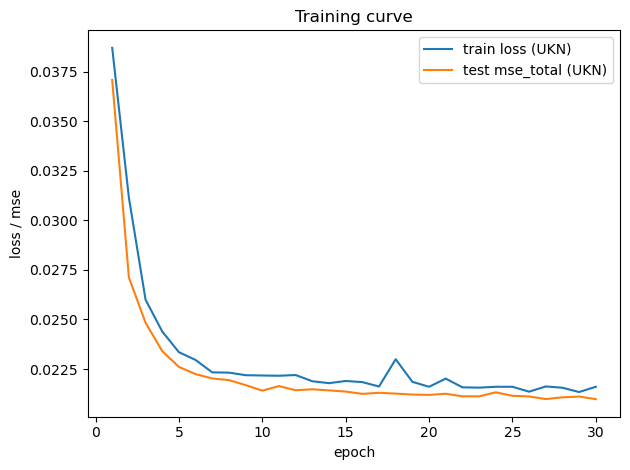

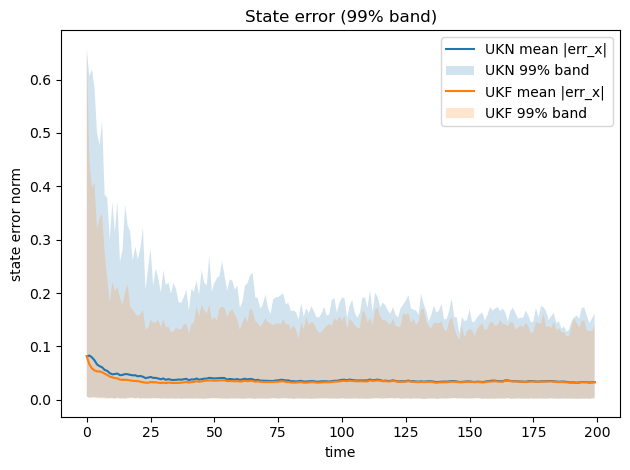

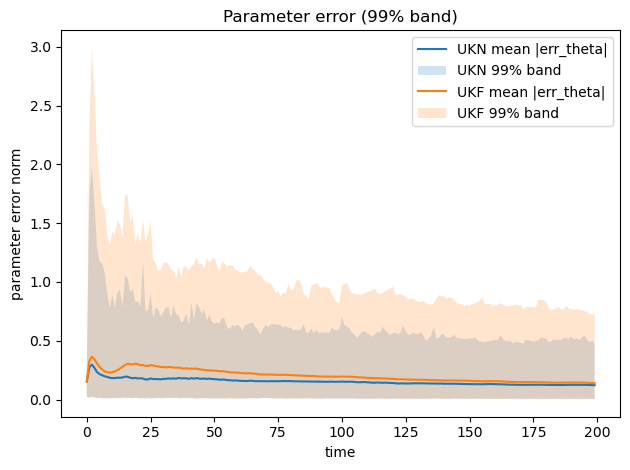

RMSE_x   UKN=0.037255 | UKF=0.032372
RMSE_th  UKN=0.140027 | UKF=0.196491


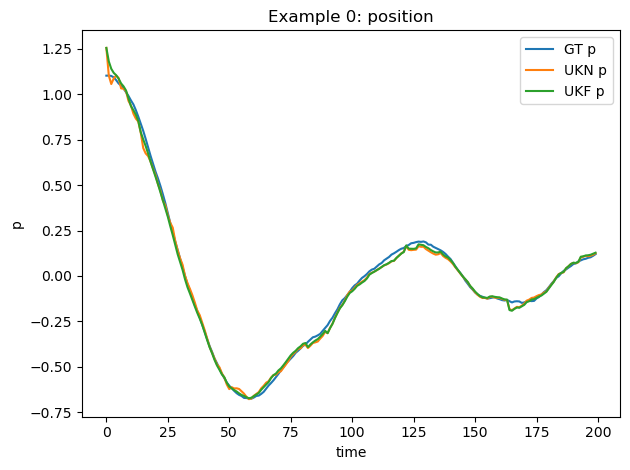

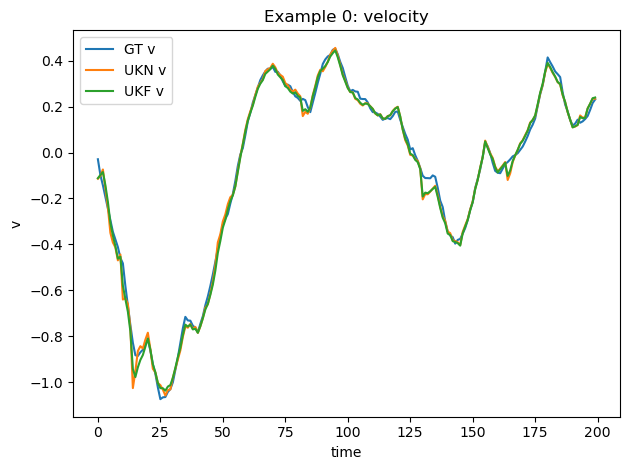

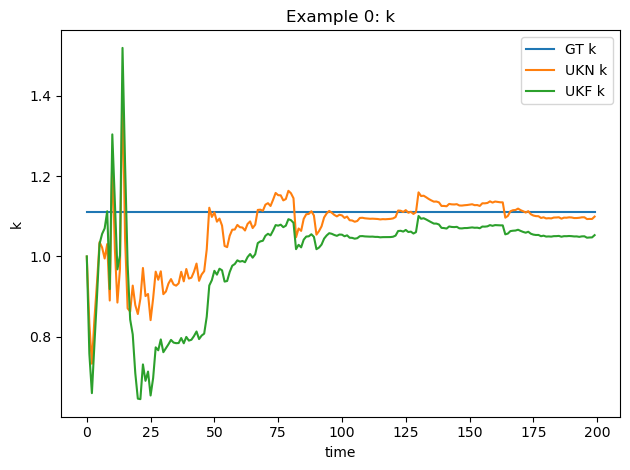

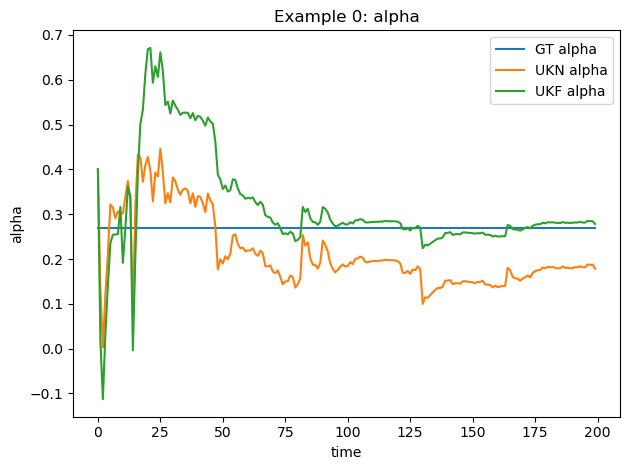

Plots saved under: results\run_20260214_013852


In [ ]:

# RESULTS_DIR = os.path.join("results", f"run_20260214_013852")

# print(os.path.join(RESULTS_DIR, "history.pt"))

history = torch.load(os.path.join(RESULTS_DIR, "history.pt"), map_location="cpu")
blob = torch.load(os.path.join(RESULTS_DIR, "test_outputs.pt"), map_location="cpu")

z_hat = blob["z_hat_test"]   # (N,T,4)
z_ukf = blob["z_ukf_test"]
x = blob["x_test"]           # (N,T,2)
theta = blob["theta_test"]   # (N,2)

N, T, _ = z_hat.shape
t_axis = np.arange(T)

# Training curve
plt.figure()
plt.plot(history["epoch"], history["train_loss"], label="train loss (UKN)")
plt.plot(history["epoch"], history["test_mse_total"], label="test mse_total (UKN)")
plt.xlabel("epoch"); plt.ylabel("loss / mse"); plt.title("Training curve")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "training_curve.png"), dpi=150)
plt.show()

def mean_band(err: np.ndarray, q_low=0.005, q_high=0.995):
    mean = np.mean(err, axis=0)
    lo = np.quantile(err, q_low, axis=0)
    hi = np.quantile(err, q_high, axis=0)
    return mean, lo, hi

# State error norm + 99% band
err_x_ukn = (z_hat[..., 0:2] - x).numpy()
err_x_ukf = (z_ukf[..., 0:2] - x).numpy()
errnorm_ukn = np.linalg.norm(err_x_ukn, axis=-1)
errnorm_ukf = np.linalg.norm(err_x_ukf, axis=-1)

m_u, lo_u, hi_u = mean_band(errnorm_ukn)
m_f, lo_f, hi_f = mean_band(errnorm_ukf)

plt.figure()
plt.plot(t_axis, m_u, label="UKN mean |err_x|")
plt.fill_between(t_axis, lo_u, hi_u, alpha=0.2, label="UKN 99% band")
plt.plot(t_axis, m_f, label="UKF mean |err_x|")
plt.fill_between(t_axis, lo_f, hi_f, alpha=0.2, label="UKF 99% band")
plt.xlabel("time"); plt.ylabel("state error norm"); plt.title("State error (99% band)")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "error_band_state.png"), dpi=150)
plt.show()

# Parameter error norm + 99% band
th_hat = z_hat[..., 2:4].numpy()
th_ukf = z_ukf[..., 2:4].numpy()
th_true = theta.numpy()[:, None, :]

err_th_ukn = np.linalg.norm(th_hat - th_true, axis=-1)
err_th_ukf = np.linalg.norm(th_ukf - th_true, axis=-1)

m_u, lo_u, hi_u = mean_band(err_th_ukn)
m_f, lo_f, hi_f = mean_band(err_th_ukf)

plt.figure()
plt.plot(t_axis, m_u, label="UKN mean |err_theta|")
plt.fill_between(t_axis, lo_u, hi_u, alpha=0.2, label="UKN 99% band")
plt.plot(t_axis, m_f, label="UKF mean |err_theta|")
plt.fill_between(t_axis, lo_f, hi_f, alpha=0.2, label="UKF 99% band")
plt.xlabel("time"); plt.ylabel("parameter error norm"); plt.title("Parameter error (99% band)")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "error_band_theta.png"), dpi=150)
plt.show()

# RMSE summary
rmse_x_ukn = float(np.sqrt(np.mean(err_x_ukn**2)))
rmse_x_ukf = float(np.sqrt(np.mean(err_x_ukf**2)))
rmse_th_ukn = float(np.sqrt(np.mean((th_hat - th_true)**2)))
rmse_th_ukf = float(np.sqrt(np.mean((th_ukf - th_true)**2)))
print(f"RMSE_x   UKN={rmse_x_ukn:.6f} | UKF={rmse_x_ukf:.6f}")
print(f"RMSE_th  UKN={rmse_th_ukn:.6f} | UKF={rmse_th_ukf:.6f}")

with open(os.path.join(RESULTS_DIR, "summary.txt"), "w") as f:
    f.write(f"RMSE_x   UKN={rmse_x_ukn:.6f} | UKF={rmse_x_ukf:.6f}\n")
    f.write(f"RMSE_th  UKN={rmse_th_ukn:.6f} | UKF={rmse_th_ukf:.6f}\n")

# Example trajectory
EXAMPLE_IDX = 0
zhat_i = z_hat[EXAMPLE_IDX].numpy()
zukf_i = z_ukf[EXAMPLE_IDX].numpy()
x_i = x[EXAMPLE_IDX].numpy()
th_i = theta[EXAMPLE_IDX].numpy()

# p
plt.figure()
plt.plot(t_axis, x_i[:,0], label="GT p")
plt.plot(t_axis, zhat_i[:,0], label="UKN p")
plt.plot(t_axis, zukf_i[:,0], label="UKF p")
plt.title(f"Example {EXAMPLE_IDX}: position"); plt.xlabel("time"); plt.ylabel("p")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, f"example_{EXAMPLE_IDX:04d}_p.png"), dpi=150)
plt.show()

# v
plt.figure()
plt.plot(t_axis, x_i[:,1], label="GT v")
plt.plot(t_axis, zhat_i[:,1], label="UKN v")
plt.plot(t_axis, zukf_i[:,1], label="UKF v")
plt.title(f"Example {EXAMPLE_IDX}: velocity"); plt.xlabel("time"); plt.ylabel("v")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, f"example_{EXAMPLE_IDX:04d}_v.png"), dpi=150)
plt.show()

# k
plt.figure()
plt.plot(t_axis, np.full_like(t_axis, th_i[0], dtype=float), label="GT k")
plt.plot(t_axis, zhat_i[:,2], label="UKN k")
plt.plot(t_axis, zukf_i[:,2], label="UKF k")
plt.title(f"Example {EXAMPLE_IDX}: k"); plt.xlabel("time"); plt.ylabel("k")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, f"example_{EXAMPLE_IDX:04d}_k.png"), dpi=150)
plt.show()

# alpha
plt.figure()
plt.plot(t_axis, np.full_like(t_axis, th_i[1], dtype=float), label="GT alpha")
plt.plot(t_axis, zhat_i[:,3], label="UKN alpha")
plt.plot(t_axis, zukf_i[:,3], label="UKF alpha")
plt.title(f"Example {EXAMPLE_IDX}: alpha"); plt.xlabel("time"); plt.ylabel("alpha")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, f"example_{EXAMPLE_IDX:04d}_alpha.png"), dpi=150)
plt.show()

print("Plots saved under:", RESULTS_DIR)


## 13) Reload-only plotting (optional)
If you already trained and have a `RESULTS_DIR`, set it and re-run the plotting cell.


In [ ]:
# Example:
# RESULTS_DIR = "results/run_YYYYMMDD_HHMMSS"
# Then re-run the plotting cell above.
